# Загрузка и обработка сырых данных

In [8]:
import numpy as np
import pandas as pd

In [9]:
all_orders = pd.read_excel('../data/BurgerKing_TimeSeries_TEST.xlsx', sheet_name='TimeSeries')

In [10]:
all_orders

,key,ds,y
0,1,2019-06-10,1
1,1,2019-06-11,14
2,1,2019-06-12,332
3,1,2019-06-13,770
4,1,2019-06-14,840
...,...,...,...
10011,5,2023-07-27,982
10012,5,2023-07-28,949
10013,5,2023-07-29,941
10014,5,2023-07-30,996


In [11]:
all_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     10016 non-null  int64         
 1   ds      10016 non-null  datetime64[ns]
 2   y       10016 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 234.9 KB


In [12]:
all_orders.describe()

,key,ds,y
count,10016.000000,10016,10016.000000
mean,3.232528,2020-09-02 06:04:53.290734592,674.183506
min,1.000000,2016-01-02 00:00:00,1.000000
25%,2.000000,2019-05-20 00:00:00,470.000000
50%,3.000000,2020-10-27 00:00:00,639.000000
75%,4.000000,2022-03-13 06:00:00,823.000000
max,5.000000,2023-07-31 00:00:00,2268.000000
std,1.351298,NaN,324.145112


In [13]:
all_orders['key'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

Базовый анализ данных:
1. В срырых данных отсутствуют явные (NaN) пропуски.
2. `key` - метка конкретного ресторана, всего 5 ресторанов.
3. `ds` - дни в которые производились заказы. Доступны данные с 2 января 2016 года по 31 июля 2023 года.
4. `y` - количество заказов в конкретный день для конкретного ресторана. Минимальное количество заказов 1, максимальное 2268.

### Изучение простоев в работе в днях по каждому из ресторанов
Сколько дней подряд не работал ресторан и сколько было таких случаев

In [60]:
def get_restaurant_by_num(df, num):
    rest_df = df[df['key'] == num].copy()
    rest_df.drop(columns='key', inplace=True)
    rest_df.columns = ['Date', 'Orders']
    
    return rest_df

In [62]:
rest_list = list(all_orders['key'].unique())
for rest_num in rest_list:
    df = get_restaurant_by_num(all_orders, rest_num)
    
    df['out_of_servise_days'] = df['Date'].diff().dt.days
    df.fillna(1, inplace=True)
    miss_days = df['out_of_servise_days'].value_counts()
    miss_days = miss_days[miss_days.index > 1]
    miss_days.sort_index(inplace=True)
    
    print(f"Restaurant {rest_num}")
    print(pd.DataFrame(miss_days))
    print()

Restaurant 1
                     count
out_of_servise_days       
17.0                     1

Restaurant 2
                     count
out_of_servise_days       
2.0                      4
3.0                      1
5.0                      1
17.0                     1

Restaurant 3
                     count
out_of_servise_days       
2.0                      3
3.0                      1
27.0                     1
61.0                     1

Restaurant 4
                     count
out_of_servise_days       
2.0                      4

Restaurant 5
                     count
out_of_servise_days       
2.0                      6
10.0                     1
21.0                     1



In [49]:
df['Days_Diff'] = df['Date'].diff().dt.days
df.fillna(1, inplace=True)
miss_days = df['Days_Diff'].value_counts()
miss_days[miss_days.index > 1]
miss_days.sort_index(inplace=True)

Days_Diff
17.0    1
Name: count, dtype: int64

In [44]:
df

,Date,Orders
0,2019-06-10,1
1,2019-06-11,14
2,2019-06-12,332
3,2019-06-13,770
4,2019-06-14,840
...,...,...
1492,2023-07-27,2060
1493,2023-07-28,2051
1494,2023-07-29,1488
1495,2023-07-30,2196


In [16]:
# df['Days_Diff'] = df['Date'].diff().dt.days
# df.fillna(1, inplace=True)

In [17]:
# df['Days_Diff'].value_counts()

In [18]:
# df[df['Days_Diff'] > 1]

In [19]:
# df.loc[291 - 10:292 + 10]

In [20]:
df.set_index('Date', inplace=True)
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_date_range)

In [21]:
df

,Orders
2019-06-10,1.0
2019-06-11,14.0
2019-06-12,332.0
2019-06-13,770.0
2019-06-14,840.0
...,...
2023-07-27,2060.0
2023-07-28,2051.0
2023-07-29,1488.0
2023-07-30,2196.0


In [22]:
start_date = df.index.min()
start_date

Timestamp('2019-06-10 00:00:00')

In [23]:
calendar = pd.read_excel('../data/BurgerKing_TimeSeries_TEST.xlsx', sheet_name='Calendar')

In [24]:
calendar

,day_id,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday
0,2016-01-01,201553,201601,2016,1,5,1,53,1,1,1,0,0
1,2016-01-02,201553,201601,2016,2,6,2,53,1,1,0,0,0
2,2016-01-03,201553,201601,2016,3,7,3,53,1,1,0,0,0
3,2016-01-04,201601,201601,2016,4,1,4,1,1,1,1,0,0
4,2016-01-05,201601,201601,2016,5,2,5,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2024-12-27,202452,202412,2024,362,5,27,52,12,4,0,0,0
3284,2024-12-28,202452,202412,2024,363,6,28,52,12,4,0,0,0
3285,2024-12-29,202452,202412,2024,364,7,29,52,12,4,0,0,0
3286,2024-12-30,202501,202412,2024,365,1,30,1,12,4,1,0,0


In [25]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   day_id           3288 non-null   datetime64[ns]
 1   week_id          3288 non-null   int64         
 2   month_id         3288 non-null   int64         
 3   year_id          3288 non-null   int64         
 4   day_year         3288 non-null   int64         
 5   day_week         3288 non-null   int64         
 6   day_number       3288 non-null   int64         
 7   week_number      3288 non-null   int64         
 8   month_number     3288 non-null   int64         
 9   quarter_number   3288 non-null   int64         
 10  is_holiday       3288 non-null   int64         
 11  is_warm          3288 non-null   int64         
 12  is_black_friday  3288 non-null   int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 334.1 KB


In [26]:
calendar_df = calendar[calendar['day_id'] >= start_date].copy()

In [27]:
calendar_df

,day_id,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday
1256,2019-06-10,201924,201906,2019,161,1,10,24,6,2,0,1,0
1257,2019-06-11,201924,201906,2019,162,2,11,24,6,2,0,1,0
1258,2019-06-12,201924,201906,2019,163,3,12,24,6,2,1,1,0
1259,2019-06-13,201924,201906,2019,164,4,13,24,6,2,0,1,0
1260,2019-06-14,201924,201906,2019,165,5,14,24,6,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2024-12-27,202452,202412,2024,362,5,27,52,12,4,0,0,0
3284,2024-12-28,202452,202412,2024,363,6,28,52,12,4,0,0,0
3285,2024-12-29,202452,202412,2024,364,7,29,52,12,4,0,0,0
3286,2024-12-30,202501,202412,2024,365,1,30,1,12,4,1,0,0


In [28]:

calendar_df.set_index('day_id', inplace=True)
full_date_range = pd.date_range(start=calendar_df.index.min(), end=calendar_df.index.max(), freq='D')
calendar_df = calendar_df.reindex(full_date_range)
calendar_df

,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday
2019-06-10,201924,201906,2019,161,1,10,24,6,2,0,1,0
2019-06-11,201924,201906,2019,162,2,11,24,6,2,0,1,0
2019-06-12,201924,201906,2019,163,3,12,24,6,2,1,1,0
2019-06-13,201924,201906,2019,164,4,13,24,6,2,0,1,0
2019-06-14,201924,201906,2019,165,5,14,24,6,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,202452,202412,2024,362,5,27,52,12,4,0,0,0
2024-12-28,202452,202412,2024,363,6,28,52,12,4,0,0,0
2024-12-29,202452,202412,2024,364,7,29,52,12,4,0,0,0
2024-12-30,202501,202412,2024,365,1,30,1,12,4,1,0,0


In [29]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2032 entries, 2019-06-10 to 2024-12-31
Freq: D
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   week_id          2032 non-null   int64
 1   month_id         2032 non-null   int64
 2   year_id          2032 non-null   int64
 3   day_year         2032 non-null   int64
 4   day_week         2032 non-null   int64
 5   day_number       2032 non-null   int64
 6   week_number      2032 non-null   int64
 7   month_number     2032 non-null   int64
 8   quarter_number   2032 non-null   int64
 9   is_holiday       2032 non-null   int64
 10  is_warm          2032 non-null   int64
 11  is_black_friday  2032 non-null   int64
dtypes: int64(12)
memory usage: 206.4 KB


### Пропуски и выбросы, поиск и заполнение

In [30]:
df

,Orders
2019-06-10,1.0
2019-06-11,14.0
2019-06-12,332.0
2019-06-13,770.0
2019-06-14,840.0
...,...
2023-07-27,2060.0
2023-07-28,2051.0
2023-07-29,1488.0
2023-07-30,2196.0


In [31]:
import matplotlib.pyplot as plt  # библиотека визуализации
import seaborn as sns

In [32]:
def box_and_hist_plots(df, feature):
    """
    Generate a combined plot with a box plot at the top
    and a histogram at the bottom for a given feature.

    Parameters:
    -----------
    df : DataFrame
        Input dataframe containing the data.
    feature : str
        The name of the column to visualize.

    Returns:
    --------
    None
        Displays the combined plot.
    """

    fig, ax = plt.subplots(
        2, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    sns.boxplot(x=df[feature], ax=ax[0])
    sns.histplot(data=df, x=feature, kde=True, ax=ax[1])

    ax[0].set(xlabel="")
    ax[0].set_title(f"Box-Plot and Distribution for '{feature}'", fontsize=12)

    plt.ylabel("Count", fontsize=10)
    plt.xlabel("Class", fontsize=10)

    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    plt.tight_layout()
    plt.show()

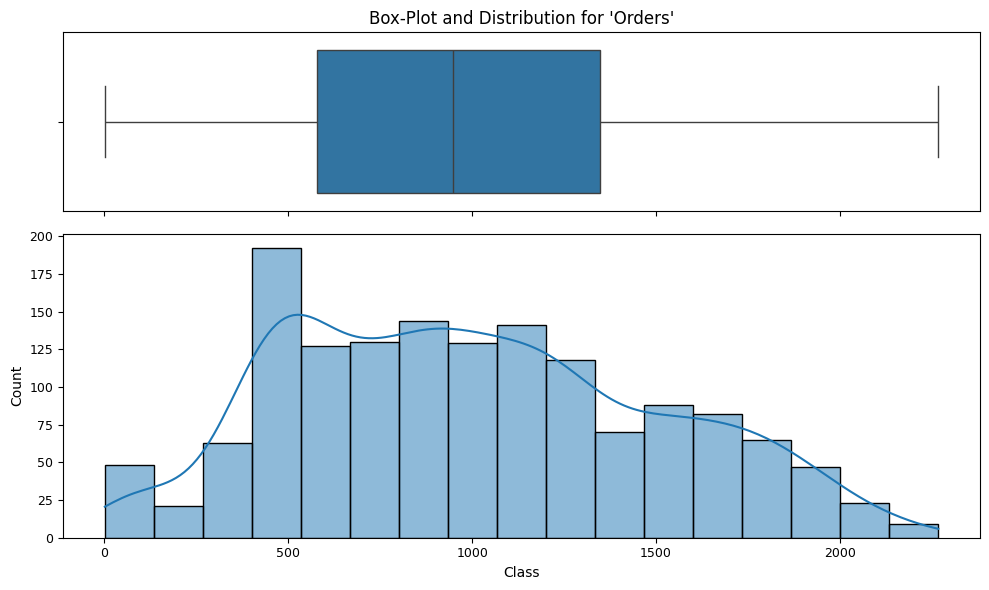

In [33]:
box_and_hist_plots(df, "Orders")

### Объединяю данные по заказам в конкретном ресторане и данные календаря

In [34]:
calendar_df.join(df, how='outer')

,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday,Orders
2019-06-10,201924,201906,2019,161,1,10,24,6,2,0,1,0,1.0
2019-06-11,201924,201906,2019,162,2,11,24,6,2,0,1,0,14.0
2019-06-12,201924,201906,2019,163,3,12,24,6,2,1,1,0,332.0
2019-06-13,201924,201906,2019,164,4,13,24,6,2,0,1,0,770.0
2019-06-14,201924,201906,2019,165,5,14,24,6,2,0,1,0,840.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,202452,202412,2024,362,5,27,52,12,4,0,0,0,NaN
2024-12-28,202452,202412,2024,363,6,28,52,12,4,0,0,0,NaN
2024-12-29,202452,202412,2024,364,7,29,52,12,4,0,0,0,NaN
2024-12-30,202501,202412,2024,365,1,30,1,12,4,1,0,0,NaN
